# Startups operations/close predictions competition #

## 1 Описание проекта

### 1.1 Исходные данные:

Датасет состоит из двух файлов (+пример с выгрузкой): тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). \
Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. \
Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

`kaggle_startups_train.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.\
`kaggle_startups_test.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Задача - предсказать значение `status` для каждого стартапа из этого датасета.\
`kaggle_startups_sample_submit.csv` - файл с примером предсказаний в правильном формате.\
`name` - идентификатор (название) стартапа в тестовом наборе.\
`status` - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].


### 1.2 Описание данных

`name` - Название стартапа\
`category_list` - Список категорий, к которым относится стартап\
`funding_total_usd` - Общая сумма финансирования в USD\
`status` - Статус стартапа (закрыт или действующий)\
`country_code` - Код страны\
`state_code` - Код штата\
`region` - Регион\
`city` - Город\
`funding_rounds` - Количество раундов финансирования\
`founded_at` - Дата основания\
`first_funding_at` - Дата первого раунда финансирования\
`last_funding_at` - Дата последнего раунда финансирования\
`closed_at` - Дата закрытия стартапа (если применимо)\
`lifetime` - Время существования стартапа в днях

### 1.3 Цель проекта

Цель проекта - провести разведочный анализ данных, исследовательский анализ данных, feature engeneering. После - создать и обучить несколько моделей машинного обучения и провести предсказания на тестовых данных. Оценить значимость каждого признака (в том числе и созданных в процессе). Подготовить отчет по исследованию.

## 2 Загрузка данных

### 2.1 Загрузка необходимых библиотек

In [2591]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import phik
import shap
import re

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, 
    AdaBoostClassifier, VotingClassifier, StackingClassifier)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:0.3f}'.format)

RANDOM_STATE = 42
TEST_SIZE = 0.25

### 2.2 Загрузка файлов и сохранение в датафреймы

In [2592]:
data_train = pd.read_csv('kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
data_test = pd.read_csv('kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])
data_submit = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')

#### 2.2.1 Проверка корректности датафреймов

In [2593]:
print(data_train.shape)
data_train.sample()

(52516, 13)


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
22919,Yospace Technologies,Mobile,932782.000,operating,GBR,N7,Staines-upon-thames,Staines-upon-thames,1,1999-01-01,2010-09-15,2010-09-15,NaT


In [2594]:
print(data_test.shape)
data_test.sample()

(13125, 11)


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
8012,IncreaseCard,Finance Technology|FinTech|Mobile Payments|SaaS,178686.000,ARG,7,Buenos Aires,Buenos Aires,5,2013-09-01,2015-02-01,1767


In [2595]:
print(data_submit.shape)
data_submit.sample()

(13125, 2)


,name,status
9768,Konarka Technologies,closed


#### 2.2.2 Промежуточный вывод

Данные загружены успешно.

## 3 Предобработка данных

### 3.1 Краткая информация о каждом датафрейме

In [2596]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [2597]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [2598]:
data_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


Данные загружены успешно, типы данных в столбцах соотвествуют заданным.

### 3.2 Анализ пропусков 

In [2599]:
pd.DataFrame(round(data_train.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
category_list,4.700000
funding_total_usd,19.200000
status,0.000000
country_code,10.500000
state_code,12.900000
region,12.100000
city,12.100000
funding_rounds,0.000000
founded_at,0.000000


В некоторых столбцах пропусков нет - это не может не радовать! При этом в `closed_at` пропусками являются почти все. Как так? Очень просто - бОльшая часть стартапов существовало на момент выгрузки, проблем в данных нет. 

Пропуски в остальных столбцах, скорее всего, являются следствием человеческого фактора - эти параметры просто не указаны. Подтвердить или опровергнуть эту гипотезу мы сможем при проведении исследовательского анализа данных.

In [2600]:
pd.DataFrame(round(data_test.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
category_list,4.500000
funding_total_usd,19.600000
country_code,10.500000
state_code,12.900000
region,12.100000
city,12.100000
funding_rounds,0.000000
first_funding_at,0.000000
last_funding_at,0.000000


Все то же самое, за исключением `closed_at` - его нет, так как он является целевым.

### 3.3 Анализ дубликатов

In [2601]:
data_train[data_train['name'].duplicated() == True]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [2602]:
data_test[data_test['name'].duplicated() == True]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


Явные дубликаты отсутствуют.

### 3.4 Промежуточный вывод

В целом, данные достаточно качественные. При этом, в некоторых ключевых столбцах достаточно много пропусков. Такой большой процент пропусков свидетельствует о человеческой ошибке, нежели об ошибке системы.

## 4 Исследовательский анализ 

### 4.1 Исследовательский анализ тренировочный выборки 

In [2603]:
data_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
13664,iSOCO,Design|Software,357000.000,operating,ESP,29,Madrid,Madrid,1,1999-01-01,2006-02-16,2006-02-16,NaT


#### 4.1.1 category_list

In [2604]:
data_train['category_list'].unique()

array(['Online Reservations|Restaurants',
       'Manufacturing|Medical|Medical Devices', 'Biotechnology', ...,
       'Gambling|Games|Online Gaming|Sports',
       'Aerospace|Mobile|Transportation|Travel',
       'Online Rental|Parking|Price Comparison'], dtype=object)

In [2605]:
data_train['category_list'].describe()

count        50051
unique       22105
top       Software
freq          3207
Name: category_list, dtype: object

Самая популярная категория - ПО. На данном этапе не очень корректно оценивать распределение сфер деятельности, так как не было произведено обобщение - уникальных категорий слишком много.

#### 4.1.2 funding_total_usd

In [2606]:
data_train['funding_total_usd'].describe()

count         42447.000
mean       18247480.657
std       187117301.321
min               1.000
25%          336027.500
50%         2000000.000
75%        10000000.000
max     30079503000.000
Name: funding_total_usd, dtype: float64

Взглянем на то, как распределены средства:

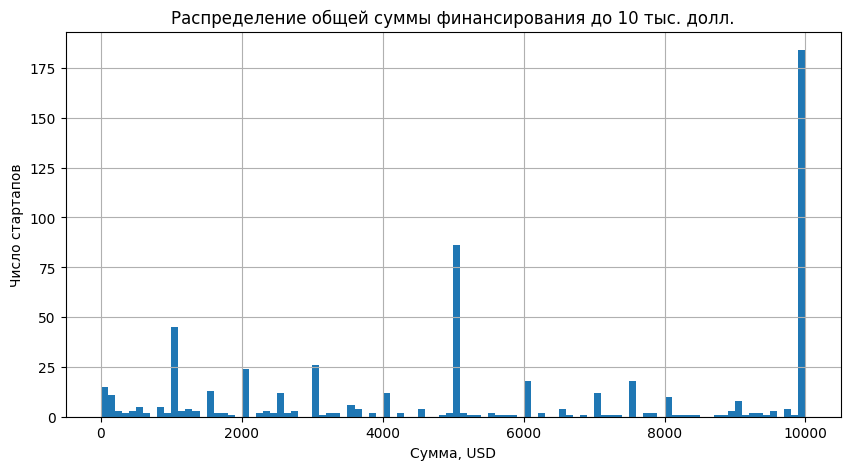

In [2607]:
data_train_funding_less_10k_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(0, 10_000), grid=True, figsize=(10, 5));

data_train_funding_less_10k_plot.set_title('Распределение общей суммы финансирования до 10 тыс. долл.')
data_train_funding_less_10k_plot.set_xlabel('Сумма, USD')
data_train_funding_less_10k_plot.set_ylabel('Число стартапов')

plt.show()

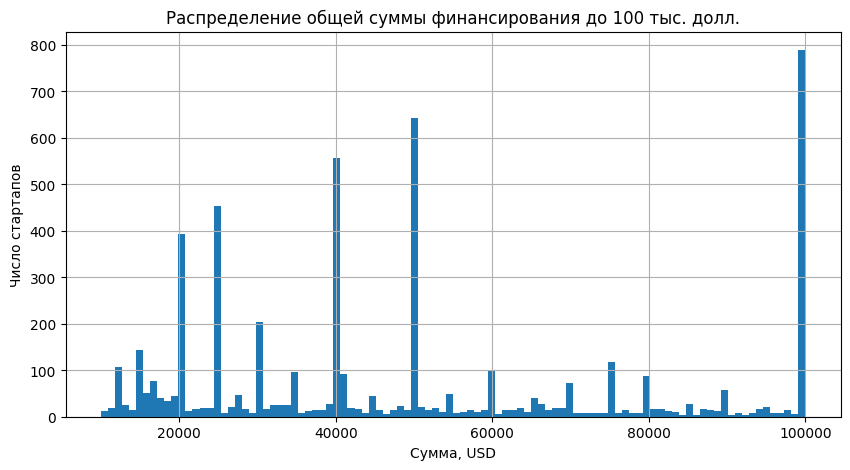

In [2608]:
data_train_funding_less_100k_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(10_001, 100_000), grid=True, figsize=(10, 5));

data_train_funding_less_100k_plot.set_title('Распределение общей суммы финансирования до 100 тыс. долл.')
data_train_funding_less_100k_plot.set_xlabel('Сумма, USD')
data_train_funding_less_100k_plot.set_ylabel('Число стартапов')

plt.show()

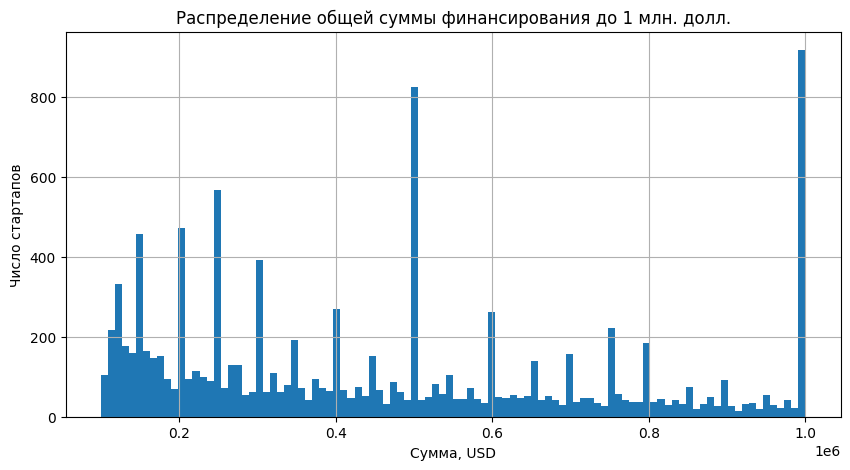

In [2609]:
data_train_funding_less_1kk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(100_001, 1_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_1kk_plot.set_title('Распределение общей суммы финансирования до 1 млн. долл.')
data_train_funding_less_1kk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_1kk_plot.set_ylabel('Число стартапов')

plt.show()

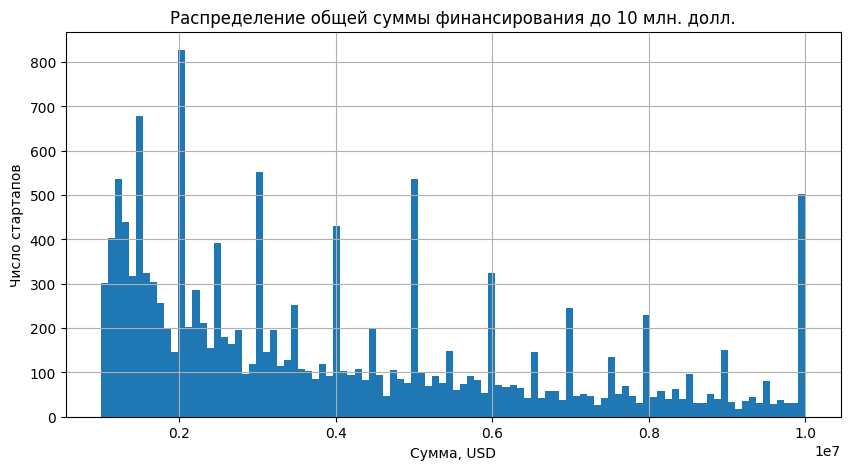

In [2610]:
data_train_funding_less_10kk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(1_000_001, 10_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_10kk_plot.set_title('Распределение общей суммы финансирования до 10 млн. долл.')
data_train_funding_less_10kk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_10kk_plot.set_ylabel('Число стартапов')

plt.show()

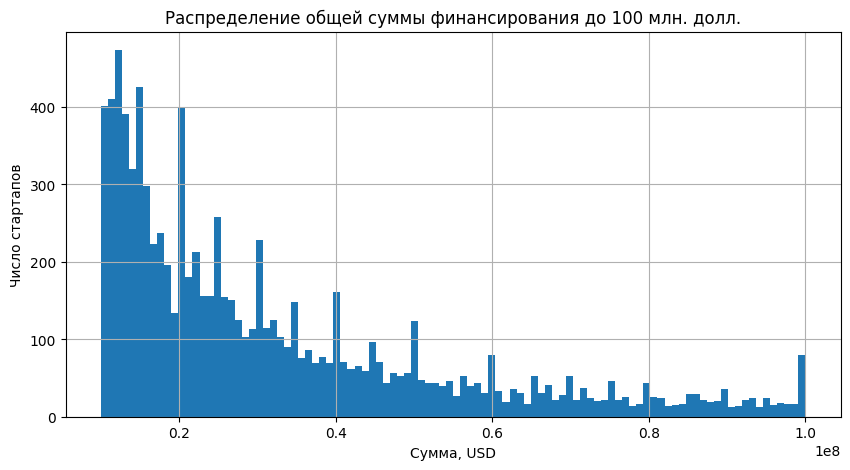

In [2611]:
data_train_funding_less_100kk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(10_000_001, 100_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_100kk_plot.set_title('Распределение общей суммы финансирования до 100 млн. долл.')
data_train_funding_less_100kk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_100kk_plot.set_ylabel('Число стартапов')

plt.show()

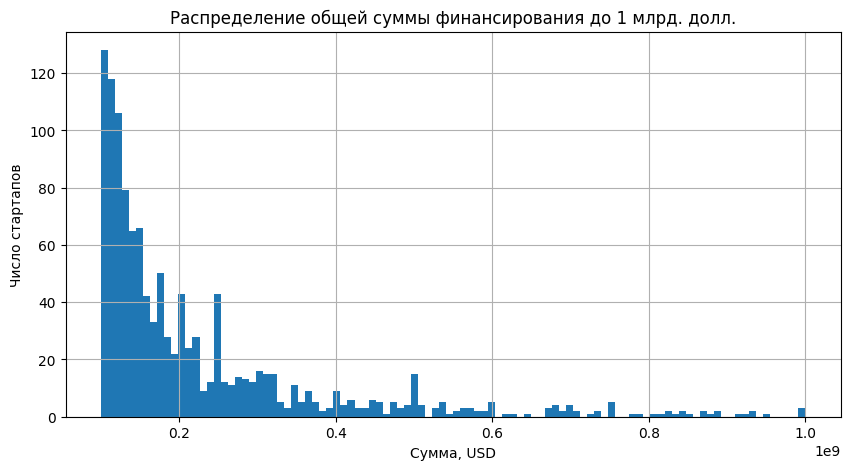

In [2612]:
data_train_funding_less_1kkk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(100_000_001, 1_000_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_1kkk_plot.set_title('Распределение общей суммы финансирования до 1 млрд. долл.')
data_train_funding_less_1kkk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_1kkk_plot.set_ylabel('Число стартапов')

plt.show()

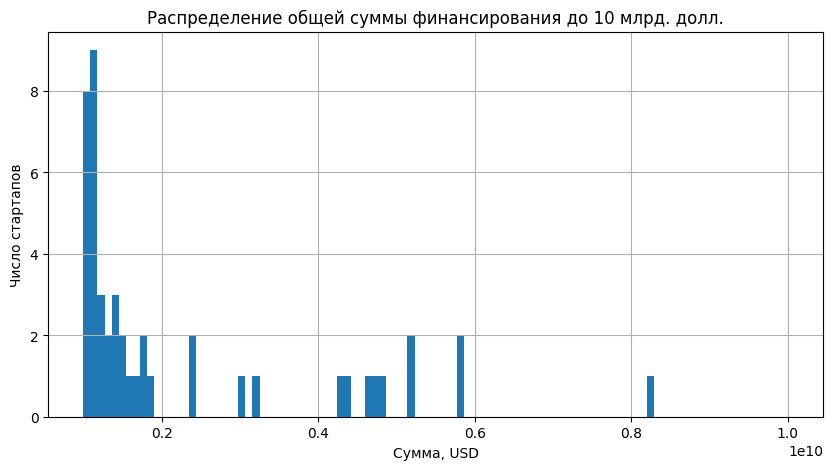

In [2613]:
data_train_funding_less_10kkk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(1_000_000_001, 10_000_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_10kkk_plot.set_title('Распределение общей суммы финансирования до 10 млрд. долл.')
data_train_funding_less_10kkk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_10kkk_plot.set_ylabel('Число стартапов')

plt.show()

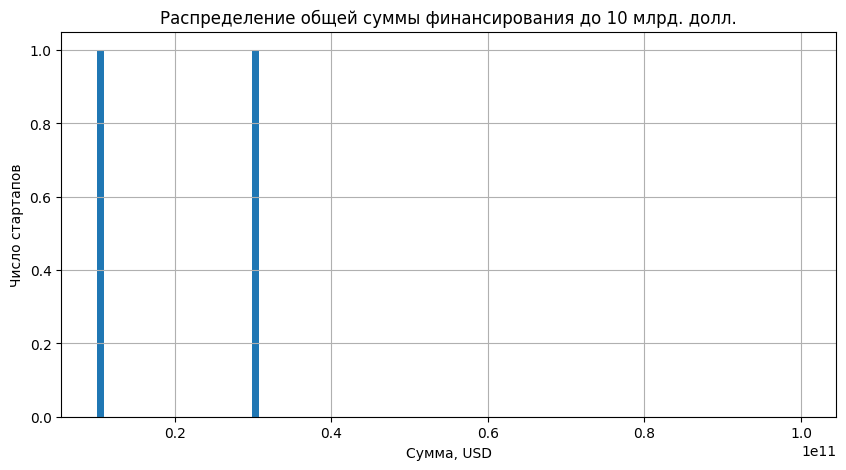

In [2614]:
data_train_funding_less_100kkk_plot = data_train['funding_total_usd'].plot(kind='hist', bins=100, range=(10_000_000_001, 100_000_000_000), grid=True, figsize=(10, 5));

data_train_funding_less_100kkk_plot.set_title('Распределение общей суммы финансирования до 10 млрд. долл.')
data_train_funding_less_100kkk_plot.set_xlabel('Сумма, USD')
data_train_funding_less_100kkk_plot.set_ylabel('Число стартапов')

plt.show()

На каждой из гистограмм видны четкие пики - это круглые числа (500 000 USD, 2 000 000 USD и т.п.) или значения рядом с ними. Чем это может быть обосновано? Чаще всего стартапы прибегают к краудфандингу, и устанавливают какое-то определенное пороговое значение инвестиций, после которого стартап может полноценно начать свою деятельность.

#### 4.1.3 status

In [2615]:
data_train['status'].describe()

count         52516
unique            2
top       operating
freq          47599
Name: status, dtype: object

In [2616]:
data_train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [2617]:
data_train_status_pivot_table = data_train.pivot_table(index='status', values='name', aggfunc='count')
data_train_status_pivot_table

,name
status,
closed,4916
operating,47599


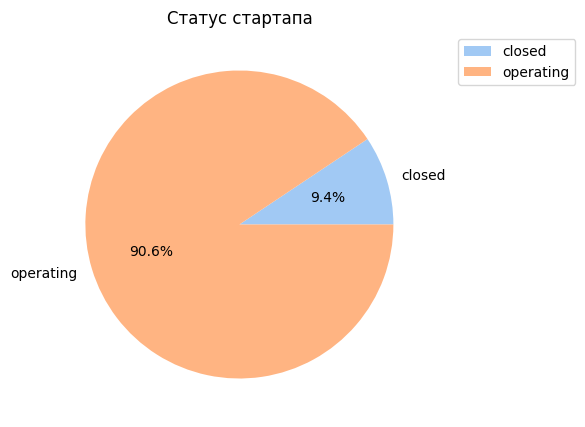

In [2618]:
data_train_status_plot = data_train_status_pivot_table.plot(kind='pie', subplots=True, 
                                                            figsize=(10, 5), autopct='%1.1f%%', colors=sns.color_palette('pastel'))

plt.title('Статус стартапа')
plt.ylabel(None)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Более 90% стартапов на момент выгрузки данных являются функционирующими. С точки зрения бизнеса значения прекрасные, а вот с точки зрения машинного обучения не очень - точно возникнет проблема дисбаланса классов.

#### 4.1.4 country_code

In [2619]:
data_train['country_code'].describe()

count     47014
unique      134
top         USA
freq      29702
Name: country_code, dtype: object

Как и ожидалось, большая часть стартапов родом из Соединенных Штатов.

In [2620]:
data_train['country_code'].unique()

array(['CHE', 'USA', nan, 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND', 'KOR',
       'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY', 'PRT',
       'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL', 'DEU',
       'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC', 'ROM',
       'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR', 'GHA',
       'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA', 'NOR',
       'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC', 'CZE',
       'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO', 'UKR',
       'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV', 'COL',
       'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD', 'UZB',
       'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND',
       'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN',
       'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'TGO',
       'RWA', '

In [2621]:
data_train_country_code_pivot_table = data_train.pivot_table(index='country_code', values='name', aggfunc='count')
data_train_country_code_pivot_table.sort_values(by='name', ascending=False)

,name
country_code,
USA,29701
GBR,2925
CAN,1540
IND,1276
CHN,1240
...,...
MNE,1
NIC,1
QAT,1


Число стартапов из Штатов в 10 раз превышает число стартапов из Великобритании.

#### 4.1.5 state_code

In [2622]:
data_train['state_code'].describe()

count     45753
unique      300
top          CA
freq      10219
Name: state_code, dtype: object

Предположительно, самым популярным местом для создания стартапа является Калифорния.

In [2623]:
data_train['state_code'].nunique()

300

In [2624]:
data_train_state_code_pivot_table = data_train.pivot_table(index='state_code', values='name', aggfunc='count')
data_train_state_code_pivot_table.sort_values(by='name', ascending=False)

,name
state_code,
CA,10219
NY,3112
MA,2020
TX,1562
H9,1510
...,...
PE,1
Q6,1
T7,1


#### 4.1.6 region

In [2625]:
data_train['region'].describe()

count           46157
unique           1036
top       SF Bay Area
freq             6970
Name: region, dtype: object

In [2626]:
data_train['region'].nunique()

1036

In [2627]:
data_train_region_pivot_table = data_train.pivot_table(index='region', values='name', aggfunc='count')
data_train_region_pivot_table.sort_values(by='name', ascending=False)

,name
region,
SF Bay Area,6970
New York City,2776
Boston,1890
London,1840
Los Angeles,1513
...,...
Royston,1
Herzogenaurach,1
NH - Other,1


И снова Калифорния, на этот раз административный округ Сан-Франциско.

#### 4.1.7 city

In [2628]:
data_train['city'].describe()

count             46157
unique             4477
top       San Francisco
freq               2824
Name: city, dtype: object

In [2629]:
data_train['city'].nunique()

4477

In [2630]:
data_train_city_pivot_table = data_train.pivot_table(index='city', values='name', aggfunc='count')
data_train_city_pivot_table.sort_values(by='name', ascending=False)

,name
city,
San Francisco,2824
New York,2486
London,1514
Austin,609
Palo Alto,607
...,...
Mohali,1
Moirans,1
Mombasa,1


В самом Сан-Франциско появилось более 2800 стартапов. При этом если смотреть на второе место, Нью-Йорк, то отрыв совсем небольшой. В то время как отличие по округам достаточно серьезное - почти в 3 раза.

#### 4.1.8 funding_rounds

In [2631]:
data_train['funding_rounds'].describe()

count   52516.000
mean        1.741
std         1.375
min         1.000
25%         1.000
50%         1.000
75%         2.000
max        19.000
Name: funding_rounds, dtype: float64

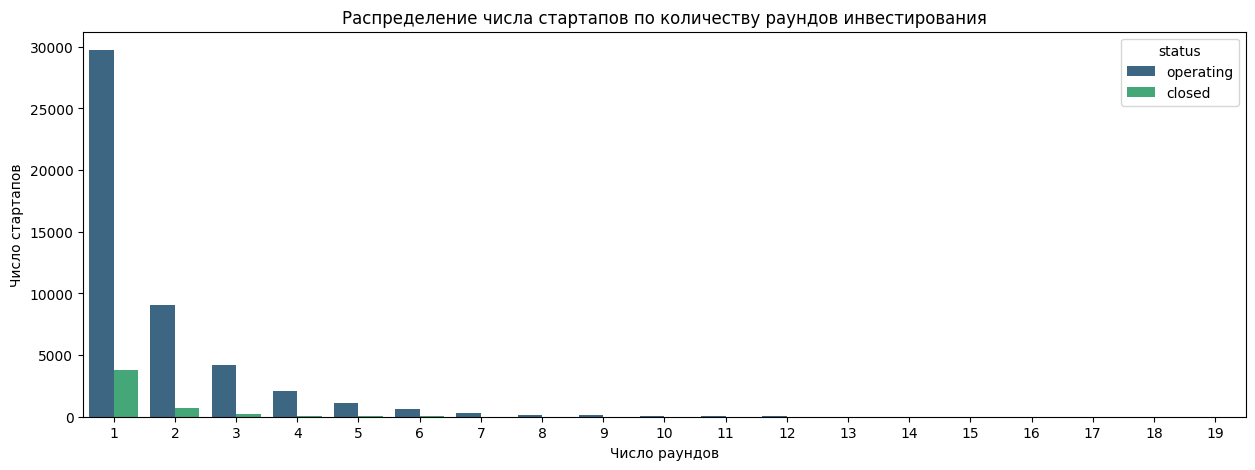

In [2632]:
plt.figure(figsize=(15, 5))
sns.countplot(x='funding_rounds', data=data_train, palette='viridis', hue='status')
    
plt.title('Распределение числа стартапов по количеству раундов инвестирования')
plt.xlabel('Число раундов')
plt.ylabel('Число стартапов')
    
plt.show()

Внушительная часть стартапов провела всего один раунд инвестирования - почти 30 тысяч. 

## 5 Корреляционный анализ

Из-за очень большого числа уникальных категориальных значений, воспользуемся случайной выборкой из тренировочной. 

In [2633]:
data_sample = data_train.sample(1000)

In [2634]:
corr_matrix = data_sample.drop(['name', 'country_code', 'state_code', 'region'],
                               axis=1).phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds'])

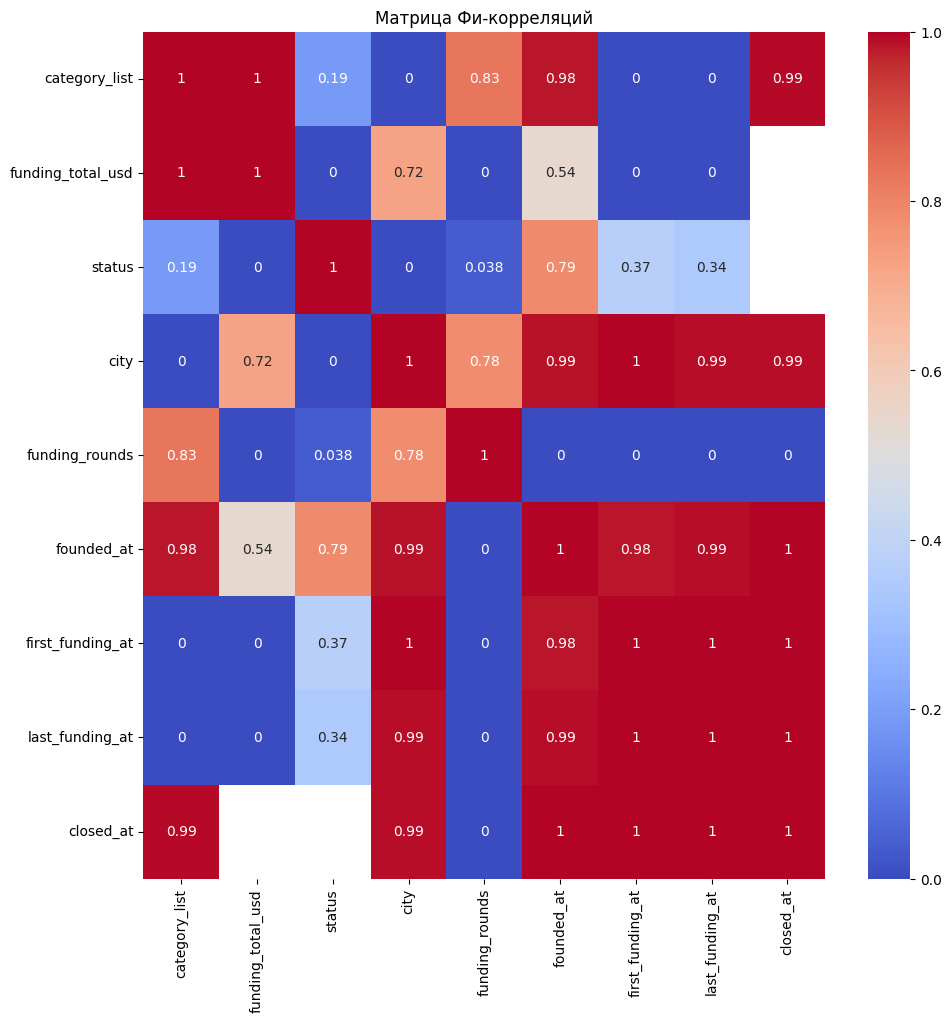

In [2635]:
plt.figure(figsize=(11, 11))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица Фи-корреляций')
plt.show()

### 5.1 Промежуточный вывод

У многих признаков видна сильная мультиколлинеарность. Вероятно, их придется удалить. 

При этом с целевым признаком проблем нет - признаков с высокой корреляцией с ним не наблюдается.

## 6 feature engeneering

Для корректного обучения придется заполнить пропуски медианным значением. Заполнять средним не вариант - слишком большое число.

In [2636]:
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].median())

data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].median())

Создадим несколько "надкатегорий" для каждой сферы деятельности стартапов.

In [2637]:
groupings = {
    'Technology': ['Technology', 'Software', 'Cloud Computing', 'Nanotechnology', 'IT and Cybersecurity', 'Robotics'],
    'Healthcare': ['Medical', 'Health Diagnostics', 'Biotechnology', 'Health Care', 'Medical Devices', 'mHealth', 'Telemedicine'],
    'Finance': ['Finance', 'FinTech', 'Investment Management', 'Financial Services', 'Payments', 'Venture Capital', 'Cryptocurrency', 'Bitcoin'],
    'E-commerce': ['E-Commerce', 'Online Shopping', 'Retail', 'Marketplaces', 'Groceries', 'Online Travel'],
    'Mobile Apps': ['Mobile', 'Apps', 'Mobile Payments', 'iOS', 'Android'],
    'Artificial Intelligence': ['Artificial Intelligence', 'Machine Learning', 'Data Analytics', 'Big Data', 'AI'],
    'Social Media': ['Social Media', 'Social Network Media', 'Photo Sharing', 'Messaging', 'Twitter Applications', 'Video Chat'],
    'Energy and CleanTech': ['Clean Energy', 'Energy', 'Environmental Innovation', 'Solar', 'Wind', 'Energy Efficiency', 'Renewable Energies'],
    'Entertainment': ['Entertainment', 'Music', 'Games', 'Media', 'Film', 'TV Production', 'Video Streaming'],
    'Education': ['Education', 'Language Learning', 'EdTech', 'E-learning', 'Online Education'],
    'Transportation': ['Transportation', 'Automotive', 'Logistics', 'Travel & Tourism', 'Shipping', 'Supply Chain Management', 'Fleet Management'],
    'Real Estate': ['Real Estate', 'Rental Housing', 'Property Management', 'Construction'],
    'Fashion': ['Fashion', 'Lifestyle', 'Clothing', 'Accessories', 'Shoes', 'Jewelry'],
    'Food & Beverage': ['Food Processing', 'Groceries', 'Restaurants', 'Specialty Foods', 'Organic Food', 'Wine and Spirits'],
    'Human Resources': ['Recruiting', 'HR', 'Job Market', 'Skill Assessment', 'Employment'],
    'Business Services': ['Consulting', 'CRM', 'Sales and Marketing', 'Optimization', 'Customer Service', 'B2B', 'Lead Generation'],
    'IoT': ['Internet of Things', 'Smart Grid', 'Wearables', 'Home Automation', 'Connected Devices'],
    'Consumer Goods': ['Consumer Electronics', 'Babies', 'Children', 'Home Automation', 'Organic Products', 'Lifestyle Products'],
    'Security': ['Cyber Security', 'Data Security', 'Network Security', 'Privacy', 'Fraud Detection'],
    'Logistics': ['Delivery', 'Supply Chain Management', 'Logistics', 'Fleet Management', 'Shipping', 'Postal Services'],
    'Media': ['Digital Media', 'Publishing', 'Journalism', 'Broadcasting', 'News', 'Music', 'Film'],
    'Sports': ['Fitness', 'Health and Wellness', 'Sports', 'Athletics', 'Outdoor Activities'],
    'Legal': ['Legal', 'Law Enforcement', 'Compliance', 'Regulatory'],
    'Automotive': ['Automotive', 'Electric Vehicles', 'Car Sharing', 'Bicycles'],
    'Retail': ['Retail', 'Shopping', 'Fashion', 'Consumer Goods'],
    'Hospitality': ['Hotels', 'Restaurants', 'Vacation Rentals', 'Hospitality']
}

def get_supercategory(category, groupings):
    if isinstance(category, str):
        for supercategory, keywords in groupings.items():
            for keyword in keywords:
                if re.search(keyword, category, re.IGNORECASE):
                    return supercategory
    return "Other"

def categorize_startups(df, column_name):
    df['supercategory'] = df[column_name].apply(lambda x: get_supercategory(x, groupings))
    return df

data_train = categorize_startups(data_train, 'category_list')
data_test = categorize_startups(data_test, 'category_list')

Введем градацию объема инвестированных средств.

In [2638]:

bins = [0, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000]

labels = [
    '0 - 10K', 
    '10K - 100K', 
    '100K - 1M', 
    '1M - 10M', 
    '10M - 100M', 
    '100M - 1B', 
    '1B - 10B', 
    '10B - 100B'
]

data_train['funding_grade'] = pd.cut(data_train['funding_total_usd'], bins=bins, labels=labels, right=False, include_lowest=True)

data_test['funding_grade'] = pd.cut(data_test['funding_total_usd'], bins=bins, labels=labels, right=False, include_lowest=True)

Добавим в тренировочный датасет признак `lifetime`, так как он есть в тестовых данных и является одним из ключевых.

In [2639]:
data_train['founded_at'] = pd.to_datetime(data_train['founded_at'])
data_train['closed_at'] = pd.to_datetime(data_train['closed_at'])

fixed_date = pd.to_datetime('2018-01-01')

data_train['lifetime'] = (data_train['closed_at'].fillna(fixed_date) - data_train['founded_at']).dt.days

Новый признак `inv_time` описывает промежуток времени от первого инвестиционного раунда до последнего.

In [2640]:
data_train['first_funding_at'] = pd.to_datetime(data_train['first_funding_at'])
data_train['last_funding_at'] = pd.to_datetime(data_train['last_funding_at'])
data_test['first_funding_at'] = pd.to_datetime(data_test['first_funding_at'])
data_test['last_funding_at'] = pd.to_datetime(data_test['last_funding_at'])

data_train['inv_time'] = (data_train['last_funding_at'] - data_train['first_funding_at']).dt.days
data_test['inv_time'] = (data_test['last_funding_at'] - data_test['first_funding_at']).dt.days

In [2641]:
data_train['country_code'] = data_train['country_code'].fillna('USA')
data_test['country_code'] = data_test['country_code'].fillna('USA')

`avg_round_freq` - периодичность проведения раундов инвестиций.\
`average_inv_round` - средний объем инвестиций за раунд.

In [2642]:
data_train['avg_round_freq'] = data_train['inv_time'] / data_train['funding_rounds']
data_train['average_inv_round'] = data_train['funding_total_usd'] / data_train['funding_rounds']

data_test['avg_round_freq'] = data_test['inv_time'] / data_test['funding_rounds']
data_test['average_inv_round'] = data_test['funding_total_usd'] / data_test['funding_rounds']

Время существования стартапов в годах:

In [2643]:
data_train['lifetime_years'] = data_train['lifetime'] / 365

data_test['lifetime_years'] = data_test['lifetime'] / 365

Категоризируем "время жизни" стартапов:

In [2644]:
def categorize_lifetime(years):
    if years < 5:
        return '0-4 years'
    elif years < 10:
        return '5-9 years'
    elif years < 15:
        return '10-14 years'
    elif years < 20:
        return '15-19 years'
    else:
        return '20+ years'

data_train['lifetime_category'] = data_train['lifetime_years'].apply(categorize_lifetime)

data_test['lifetime_category'] = data_test['lifetime_years'].apply(categorize_lifetime)

## 7 Создание пайплайна

In [2645]:
pd.DataFrame(round(data_train.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
category_list,4.700000
funding_total_usd,0.000000
status,0.000000
country_code,0.000000
state_code,12.900000
region,12.100000
city,12.100000
funding_rounds,0.000000
founded_at,0.000000


In [2646]:
data_train.sample(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,supercategory,funding_grade,lifetime,inv_time,avg_round_freq,average_inv_round,lifetime_years,lifetime_category
27615,Melinta,Biotechnology,282500000.000,operating,USA,CT,Hartford,New Haven,7,2000-01-01,2009-01-25,2015-06-10,NaT,Technology,100M - 1B,6575,2327,332.429,40357142.857,18.014,15-19 years
13149,Davia,Mobile,2000000.000,closed,USA,NaN,NaN,NaN,1,2011-01-01,2010-11-01,2010-11-01,2012-03-29,Mobile Apps,1M - 10M,453,0,0.000,2000000.000,1.241,0-4 years
25533,Redeem,Environmental Innovation,24384296.000,operating,GBR,NaN,NaN,NaN,2,2012-10-18,2014-09-18,2014-09-18,NaT,Energy and CleanTech,10M - 100M,1901,0,0.000,12192148.000,5.208,5-9 years


In [2647]:
cols_to_delete_train = ['name', 'category_list', 'status', 'country_code', 'state_code', 'region', 'city', 
                        'founded_at', 'first_funding_at','last_funding_at', 'closed_at', 'lifetime']

cols_to_delete_test = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city', 
                       'first_funding_at', 'last_funding_at', 'lifetime']

In [2648]:
X = data_train.drop(cols_to_delete_train, axis=1)
y = data_train['status']

In [2649]:
X_test = data_test.drop(cols_to_delete_test, axis=1)

In [2650]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [2651]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [2652]:
label = LabelEncoder()
label.fit(['closed', 'operating'])

y_train_la = label.transform(y_train)
y_valid_la = label.transform(y_valid)

In [2653]:
ohe_columns = ['supercategory']

ord_columns = ['funding_grade', 'lifetime_category']

num_columns = ['funding_total_usd', 'funding_rounds', 'inv_time', 'avg_round_freq', 'average_inv_round', 'lifetime_years']

In [2654]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
        ('ord', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[
                ['100K - 1M', '10M - 100M', '1M - 10M', '10K - 100K', 
                 '100M - 1B', '0 - 10K', '1B - 10B', '10B - 100B'],
                
                ['5-9 years', '10-14 years', '15-19 years', '20+ years','0-4 years']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan))
        ]), ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [2655]:
pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('models', GradientBoostingClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=6, 
                                          min_samples_split=2, min_samples_leaf=1, subsample=0.8, max_features='sqrt'))
])

In [2656]:
pipeline.fit(X_train, y_train_la)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['supercategory']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['100K '
                                                                                               '- '
                                                                                               '1M',
                                                                                               '10M '
                                                                                               '- '
                                                                                               '100M',
                                                                                               '1M '
                                                                                               '- '
                                                                                               '10M',
                                                                                               '10K '
                                                                                               '- '...
                                                                                               'years']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['funding_grade',
                                                   'lifetime_category']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'inv_time',
                                                   'avg_round_freq',
                                                   'average_inv_round',
                                                   'lifetime_years'])])),
                ('models',
                 GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                                            n_estimators=300, random_state=42,
                                            subsample=0.8))])

In [2657]:
y_pred = pipeline.predict(X_valid)
y_probs = pipeline.predict_proba(X_valid)[:, 1]

In [2658]:
f1_sc = f1_score(y_valid_la, y_pred)

roc_auc = roc_auc_score(y_valid_la, y_probs)
precision = precision_score(y_valid_la, y_pred)
recall = recall_score(y_valid_la, y_pred)

print(f'ROC AUC: {roc_auc:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
f1_sc

ROC AUC: 0.92
Precision: 0.96
Recall: 0.99


0.9732105830637804

In [2660]:
y_probs = pipeline.predict_proba(X_valid)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_probs >= threshold).astype(int)
    
    f1 = f1_score(y_valid_la, y_pred_thresholded)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold}, F1: {optimal_f1_score}")

Оптимальный порог: 0.47000000000000003, F1: 0.9733780482755765


In [2661]:
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

In [2662]:
f1_optimal = f1_score(y_valid_la, y_pred_optimal)
print(f"F1-метрика с оптимальным порогом: {f1_optimal}")

F1-метрика с оптимальным порогом: 0.9733780482755765


In [2663]:
y_pred_test = pipeline.predict(X_test)

y_pred_optimal = (y_pred_test >= optimal_threshold).astype(int)

y_preds = pd.Series(label.inverse_transform(y_pred_test))

In [2664]:
y_preds.value_counts()

operating    12182
closed         943
Name: count, dtype: int64

In [2667]:
data_subs = pd.DataFrame({'name' : data_test['name'], 'status' : y_preds})

In [2666]:
data_subs.to_csv('submission.csv', index=False)

## 8 Анализ важности признаков

In [2683]:
feature_importances  = pipeline.named_steps['models'].feature_importances_
    
feature = pipeline[:-1].get_feature_names_out()

feature_importance = pd.DataFrame(
    {
        'Feature' : feature,
        'Importance' : feature_importances
    })


feature_importance.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
33,num__lifetime_years,0.661
27,ord__lifetime_category,0.146
32,num__average_inv_round,0.040
28,num__funding_total_usd,0.038
31,num__avg_round_freq,0.030
30,num__inv_time,0.029
18,ohe__supercategory_Other,0.016
29,num__funding_rounds,0.012
26,ord__funding_grade,0.007
24,ohe__supercategory_Technology,0.002


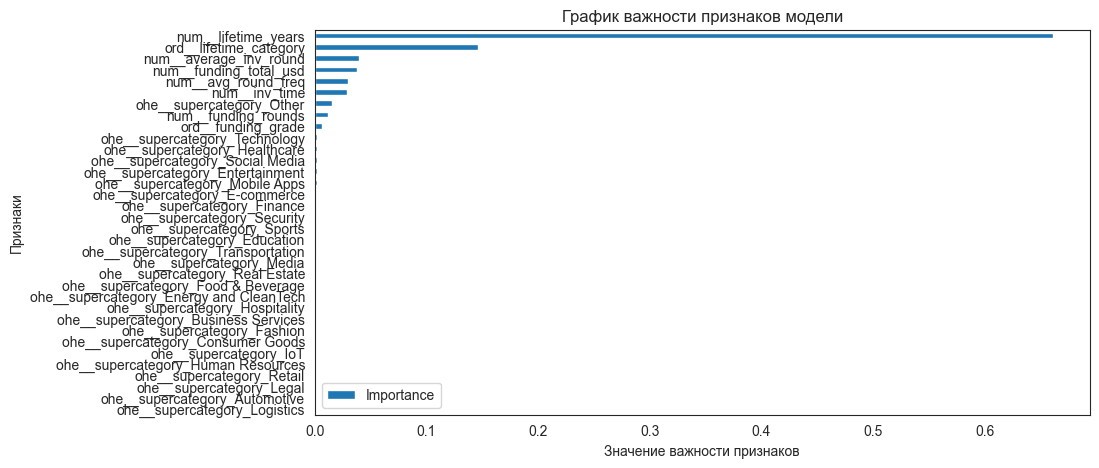

In [2684]:
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 5))

plt.title('График важности признаков модели')
plt.xlabel('Значение важности признаков')
plt.ylabel('Признаки')

plt.show()

All-NaN slice encountered


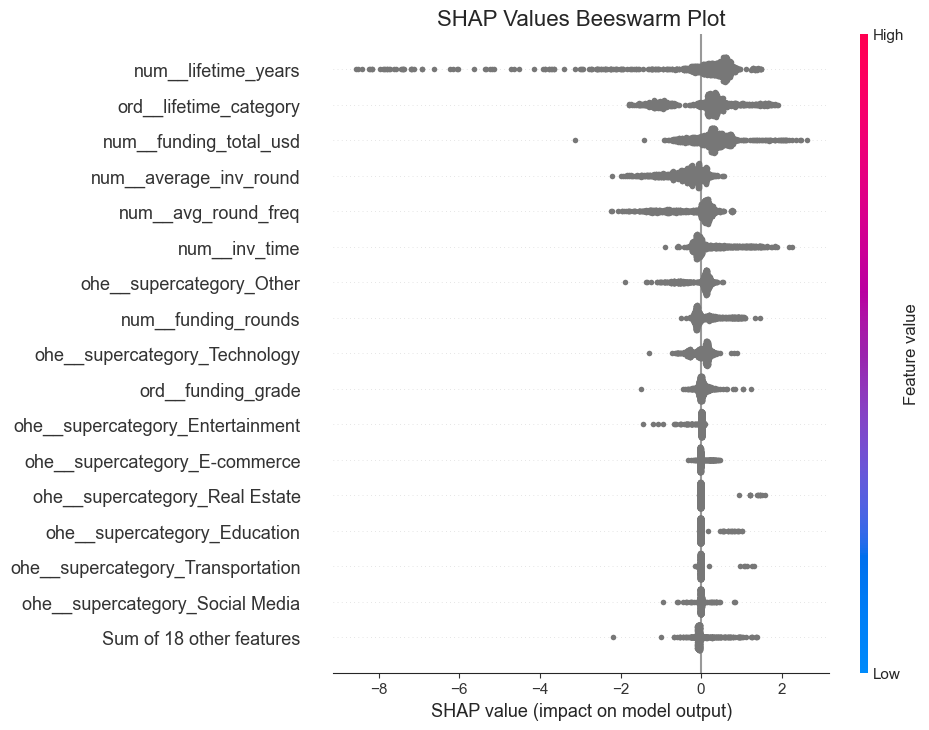

In [2690]:
explainer = shap.TreeExplainer(pipeline.named_steps['models'])

X_valid_processed = pipeline.named_steps['preprocessor'].transform(X_valid.sample(1000))

X_valid_sampled = pd.DataFrame(X_valid_processed)

shap_values = explainer.shap_values(X_valid_sampled)

if isinstance(shap_values, list):
    shap_values_class_1 = shap_values[1]  
else:
    shap_values_class_1 = shap_values  

X_valid_df = pd.DataFrame(X_valid_sampled, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

shap_values_explanation = shap.Explanation(
    values=shap_values_class_1,
    base_values=explainer.expected_value,
    data=X_valid_df 
)

plt.title('SHAP Values Beeswarm Plot', fontsize=16)
shap.plots.beeswarm(shap_values_explanation, max_display=17)

plt.show()

#### 8.1 Промежуточный вывод

Наибольшее влияние на предсказания модели оказывают такие признаки как `lifetime_years`, `lifetime_category`, а также иные признаки, связанные с временными отрезками и суммой инвестированных средств.

## 9 Итоги

<span style="color: #2E86C1; font-size: 28px;">Итоговый вывод</span> 

<span style="color: #239B56; font-size: 24px;">1. Описание и обработка данных</span> \
На этапе предобработки данных были применены следующие шаги:

- Использование инструментов визуализации для поисков закономерностей в данных.

- Проведен корреляционный анализ.

В результате были выявлены признаки, содержащие выбросы, а также определены признаки с высокой степенью корреляции - обнаружена проблема мультиколлинеарности.

<span style="color: #239B56; font-size: 24px;">2. Обучение модели МО</span> \
На данном этапе выполнения проекта был проведен отбор признаков для обучение модели и создан пайплайн.

- Проведен feature engeneering.

- Отобраны признаки для обучения модели, а также созданы новые, более полно описывающие данные.

При создании пайплайна:

- Использованы кодировщики LalelEncoder, OneHotEncoder, OrdinalEncoder.
- Для численных признаков: MinMaxScaler, StandardScaler.

- Использована модель градиентного бустинга GradientBoostClassifier.

- Изучены как целевые метрики, так и некоторые дополнительные (для дополнительной оценки модели

Создан пайплайн, включающий в себя подготовку данных, обучение модели. Проведена оценка метрик на валидационной выборке.\
Создан датафрейм с предсказаниями для тестовой выборки.

<span style="color: #239B56; font-size: 24px;">3. Визуализация SHAP</span> \
На следующем этапе были рассчитаны значения SHAP, которые визуализировали влияние признаков на предсказания модели. Для этого использовался график Beeswarm Plot.

Наиболее значимые признаки:
- `lifetime_years` (Количество лет существования компании)

- `lifetime_category` (Категория по продолжительности)

- Признаки, связанные с временными интервалами и суммой инвестированных средств.

Эти признаки оказывают наибольшее влияние на предсказания модели, указывая на важность временных и финансовых показателей.

<span style="color: #239B56; font-size: 24px;">4. Вывод</span> \
При выполении проекта были использованы датасеты, содержащие информацию о стартапах. Поставленная задача выполнена - создана модель МО, предсказывающая, закрылся ли тот или иной стартап на основе имеющихся данных. 

В процессе реализации проекта были использованы методы из таких библиотек, как `sklearn`, `pandas`, `phik`, `shap` и другие. 